构建基于01规则的Agent
- 以三元组的形式描述规则
- 只涉及三种状态：否-1、未知-0、是-1

缺点：
- 所有规则在检查每个节点的时候都会全部检查，而不是按节点不同情况来触发->自动机
- 远距离的触发无法实现->缺乏标记排雷的功能

['is', 'is_near', 'is_not', 'is_surrounded_by']
self.do_is_surrounded_by('pit','breeze','pit is_surrounded_by breeze')
self.do_is_surrounded_by('wumpus','stench','wumpus is_surrounded_by stench')
self.do_is_surrounded_by('gold','spark','gold is_surrounded_by spark')
self.do_is_near('breeze','pit','breeze is_near pit')
self.do_is_near('stench','wumpus','stench is_near wumpus')
self.do_is_near('spark','gold','spark is_near gold')
self.do_is_not('safe','wumpus','safe is_not wumpus')
self.do_is_not('safe','pit','safe is_not pit')
self.do_is_not('wumpus','safe','wumpus is_not safe')
self.do_is_not('wumpus','pit','wumpus is_not pit')
self.do_is_not('wumpus','gold','wumpus is_not gold')
self.do_is_not('pit','safe','pit is_not safe')
self.do_is_not('pit','wumpus','pit is_not wumpus')
self.do_is_not('pit','gold','pit is_not gold')
self.do_is_not('gold','wumpus','gold is_not wumpus')
self.do_is_not('gold','pit','gold is_not pit')
update (0, 0)
update (1, 0)
update (0, 1)


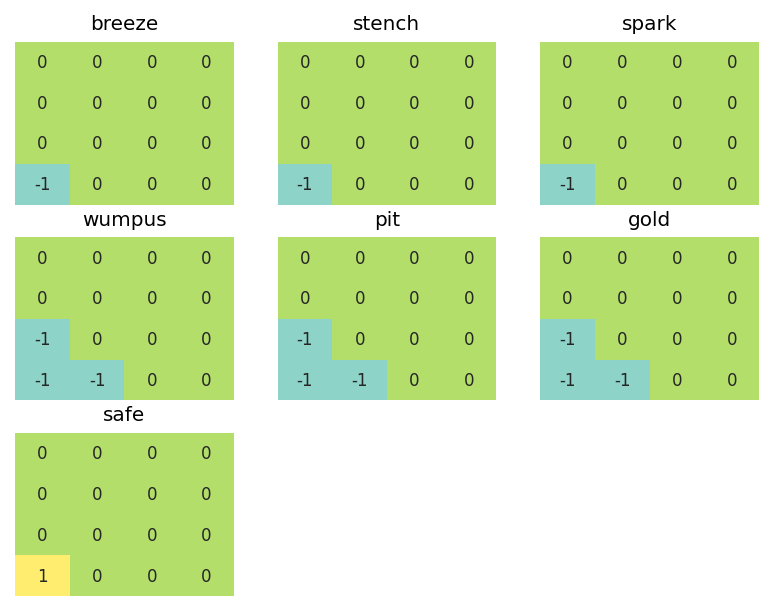

In [11]:
import numpy as np
import pandas as pd
import inspect
from pprint import pp
import matplotlib.pyplot as plt
import seaborn as sns

class Thing:
    def __init__(self, name=''):
        self.name = name
    def __repr__(self):
        return self.name

class Rule(Thing):
    def __init__(self, name=''):
        self.name = name
    # 进行更新，不判断是否成立
    # 更新只在必要时更新
    def update(self, loc):
        pass
    # 检查是否成立，不更新
    # 成立时返回True，不成立或条件不足时均返回False
    def check(self, loc):
        pass
    def node_nearby(self, lx, ly, loc):  # 生成上下左右的点
        (x0, y0) = loc
        rs_xy = []
        for x, y in [(x0, y0 - 1), (x0, y0 + 1), (x0 - 1, y0), (x0 + 1, y0)]:
            if x >= 0 and x < lx and y >= 0 and y < ly:
                rs_xy.append((x, y))
        return rs_xy

# a周围全是b
# surround和near并不同，a可以被b包围，但b周围不见得一定需要a
# update: 如果a这个点为1，那么b的点就必须是1，如果不是，则更新
# check： 如果b的这个点为-1，那么a的点就必须是-1，如果不是，那么rule不成立
class RuleSurrounded(Rule):
    def __init__(self, kb, a, b, name=''):
        super().__init__(name)
        self.kb = kb
        self.a = a
        self.b = b
    def update(self, loc):
        (x0, y0) = loc
        if self.a[x0][y0] == 1:
            for (x, y) in self.node_nearby(len(self.b), len(self.b[0]), (x0, y0)):
                if self.b[x][y] == 0:
                    self.b[x][y] = 1
                    # 因为该值做了修改，需要更新该点所相关的所有状态
                    self.kb.add_update_if_not_exists((x0, y0))
                elif self.b[x][y] == -1:
                    print("遇到更新冲突！")
    def check(self, loc):
        (x0, y0) = loc
        if self.b[x0][y0] == -1:
            for (x, y) in self.node_nearby(len(self.b), len(self.b[0]), (x0, y0)):
                if self.a[x][y] == 1:
                    return False
        return True

# a附近有b
# update: a如果为1，附近一定有b，如果a附近就剩一个点是可能是b，那么这个点一定是b
# update: a如果为-1，附近一定没有b
# check: 如果b的这个点为-1，那么a的点就不可以是1，否则不成立
class RuleIsNear(Rule):  # a周围存在b
    def __init__(self, kb, a, b, name=''):
        super().__init__(name)
        self.kb = kb
        self.a = a
        self.b = b
    def update(self, loc):
        (x0, y0) = loc
        if self.a[x0][y0]==1:
            found = False
            not_sure_nodes = []
            for (x, y) in self.node_nearby(len(self.b), len(self.b[0]), (x0, y0)):
                if self.b[x][y] == 1:
                    found = 1
                elif self.b[x][y] == 0:  # 如果这个点的值还不定
                    not_sure_nodes.append((x, y))
            # 如果周围没有，且未访问过（=不确定）的点只有一个，则该点一定是1
            if not found and len(not_sure_nodes) == 1:
                (x, y) = not_sure_nodes[0]
                self.b[x][y] = 1
                self.kb.add_update_if_not_exists((x, y))
        elif self.a[x0][y0] == -1:
            for (x, y) in self.node_nearby(len(self.b), len(self.b[0]), (x0, y0)):
                if self.b[x][y] == 0:
                    self.b[x][y] = -1
                    self.kb.add_update_if_not_exists((x, y))
                elif self.b[x][y] == 1:
                    print("遇到更新冲突！")
    def check(self, loc):
        (x0, y0) = loc
        if self.b[x0][y0] == -1:
            for (x, y) in self.node_nearby(len(self.b), len(self.b[0]), (x0, y0)):
                if self.a[x][y] == 1:
                    return False
        return True

# a是b
# update: 如果a为True，b必须是True
# check： 如果b为False，a必须是False，否则rule不成立
class RuleIs(Rule):
    def __init__(self, kb, a, b, name=''):  # a is b
        super().__init__(name)
        self.kb = kb
        self.a = a
        self.b = b
    def update(self, loc):
        (x0, y0) = loc
        if self.a[x0][y0] == 1:
            if self.b[x0][y0] == 0:
                self.b[x0][y0] = 1
                self.kb.add_update_if_not_exists((x0, y0))  # 如果有变化，就重新检查一遍
            elif self.b[x0][y0] == -1:
                print("遇到更新冲突！")
    def check(self, loc):
        (x0, y0) = loc
        return self.b[x0][y0] == -1 and self.a[x0][y0] == -1

# a不是b
# update: 如果a为True，b必须是False
# check： 如果b为True，a必须是False，否则rule不成立
class RuleIsNot(Rule):
    def __init__(self, kb, a, b, name=''):  # a is b
        super().__init__(name)
        self.kb = kb
        self.a = a
        self.b = b
    def update(self, loc):
        (x0, y0) = loc
        if self.a[x0][y0] == 1:
            if self.b[x0][y0] == 0:
                self.b[x0][y0] = -1
                self.kb.add_update_if_not_exists((x0, y0))  # 如果有变化，就重新检查一遍
            elif self.b[x0][y0] == 1:
                print("遇到更新冲突！")
    def check(self, loc):
        (x0, y0) = loc
        return self.b[x0][y0] == 1 and self.a[x0][y0] == -1

class KB(Thing):
    def __init__(self, name=''):
        self.name = name
    def learn(self, expr):  # 学习
        pass
    def ask(self, loc, expr):  # 询问某个点的情况
        pass

class WumpusKB(KB):
    def __init__(self, name='', n=4):
        super().__init__(name)
        # bool_arr = np.zeros((4,4)).astype(int).tolist()
        # 一开始我们并没有发现任何状态，默认全局安全
        not_sure_arr = np.zeros((n, n), dtype=int)
        self.stench = not_sure_arr.copy()
        self.breeze = not_sure_arr.copy()
        self.spark = not_sure_arr.copy()
        self.wumpus = not_sure_arr.copy()
        self.pit = not_sure_arr.copy()
        self.gold = not_sure_arr.copy()
        self.safe = not_sure_arr.copy()
        self.all_states = ['stench', 'breeze', 'spark', 'wumpus', 'pit', 'gold', 'safe']
        self.all_recepts = ['stench', 'breeze', 'spark', 'wumpus', 'pit', 'gold']
        self.rules = []  # 需要挨个检查的规则
        self.dolist = [dof[0][3:] for dof in inspect.getmembers(self, predicate=inspect.ismethod) if
                       dof[0].startswith("do_")]  # 有多少内置方法
        print(self.dolist)
        self.update_queue = []
    def learn(self, expr):
        toks = expr.strip().split(" ")
        if len(toks) == 3 and toks[1] in self.dolist:  # 检查输入的三元组是否合法
            eval_str = "self.do_{}('{}','{}','{}')".format(toks[1], toks[0], toks[2], expr)
            print(eval_str)
            eval(eval_str)
        else:
            print("请检查输入的指令")
    def ask(self, loc, expr):
        (x0, y0) = loc
        map_key = eval("self.{}".format(expr))
        if map_key[x0][y0] != 0:  # 如果这个点的情况已知，直接返回即可
            print("{}{}的{}为{}".format(x0, y0, expr, map_key[x0][y0]))
        else:  # 如果情况未知，则将该点设置为-1和+1，再测试所有的规则是否满足
            map_key[x0][y0] = 1
            check_1 = True
            for rule in self.rules:
                if not rule.check((x0, y0)):
                    check_1 = False
                    break
            map_key[x0][y0] = -1
            check_2 = True
            for rule in self.rules:
                if not rule.check((x0, y0)):
                    check_2 = False
                    break
            # 如果规则满足时，状况单一，则得到确定结果
            if check_1 and not check_2:
                map_key[x0][y0] = 1
                self.add_update_if_not_exists((x0, y0))
                print("{}{}的{}为1".format(x0, y0, expr))
            elif not check_1 and check_2:
                map_key[x0][y0] = -1
                self.add_update_if_not_exists((x0, y0))
                print("{}{}的{}为-1".format(x0, y0, expr))
            # 如果规则均满足或均不满足，则还无法得到结果
            else:
                map_key[x0][y0] = 0
                print("无法判断{}{}的{}".format(x0, y0, expr))
    # 如果更新队列中没有某个点，则将其加入检查队列
    def add_update_if_not_exists(self, loc):
        if loc not in self.update_queue:
            self.update_queue.append(loc)
    # 从检查队列中按顺序检查每个点
    def update_all_node(self):
        while len(self.update_queue) > 0:
            loc = self.update_queue.pop()
            print("update", loc)
            for rule in self.rules:
                rule.update(loc)
                # print(self.update_queue)
    def visit(self, loc, views=[]):  # state是看到这个点的情况
        (x0, y0) = loc
        # print(eval_str)
        for view in views:
            map_key = eval("self.{}".format(view))
            map_key[x0][y0] = 1
        # 如果没有接收到某些感受器的信号，那么将其置为-1
        for recept in self.all_recepts:
            if recept not in views:
                map_key = eval("self.{}".format(recept))
                map_key[x0][y0] = -1
        self.update_queue.append((x0, y0))
        self.update_all_node()
        self.show()
    def do_is(self, a, b, expr):  # 是命题
        map_a = eval("self." + a)
        map_b = eval("self." + b)
        rule = RuleIs(self, map_a, map_b, expr)
        self.rules.append(rule)
    def do_is_not(self, a, b, expr):  # 否命题
        map_a = eval("self." + a)
        map_b = eval("self." + b)
        rule = RuleIsNot(self, map_a, map_b, expr)
        self.rules.append(rule)
    def do_is_surrounded_by(self, a, b, expr):  # a周围一定是b
        map_a = eval("self." + a)
        map_b = eval("self." + b)
        rule = RuleSurrounded(self, map_a, map_b, expr)
        self.rules.append(rule)
    def do_is_near(self, a, b, expr):  # a附近一定存在b
        map_a = eval("self." + a)
        map_b = eval("self." + b)
        rule = RuleIsNear(self, map_a, map_b, expr)
        self.rules.append(rule)
    def show(self):
        plt.rcdefaults()
        plt.rcParams['figure.dpi'] = 150
        plt.rcParams['font.size'] = 8
        for idx, name in zip(range(1, 100), self.all_states):
            plt.subplot(3, 3, idx)
            map_key = eval("self.{}".format(name))
            ax = sns.heatmap(map_key,
                             cmap='Set3',
                             center=0,
                             annot=True,
                             cbar=False,
                             xticklabels=0,
                             yticklabels=0
                             )
            ax.invert_yaxis()
            plt.title(name)
        plt.show()

kb = WumpusKB()
# 周边规则
kb.learn("pit is_surrounded_by breeze")
kb.learn("wumpus is_surrounded_by stench")
kb.learn("gold is_surrounded_by spark")
kb.learn("breeze is_near pit")
kb.learn("stench is_near wumpus")
kb.learn("spark is_near gold")
# 互斥规则
kb.learn("safe is_not wumpus")  # 如果这个点安全，一定没有wumpus
kb.learn("safe is_not pit")
kb.learn("wumpus is_not safe")  # 如果有wumpus，一定不安全
kb.learn("wumpus is_not pit")
kb.learn("wumpus is_not gold")
kb.learn("pit is_not safe")
kb.learn("pit is_not wumpus")
kb.learn("pit is_not gold")
kb.learn("gold is_not wumpus")
kb.learn("gold is_not pit")
# 增加事实
kb.visit((0, 0), ['safe'])


update (0, 1)
update (1, 1)
update (0, 2)


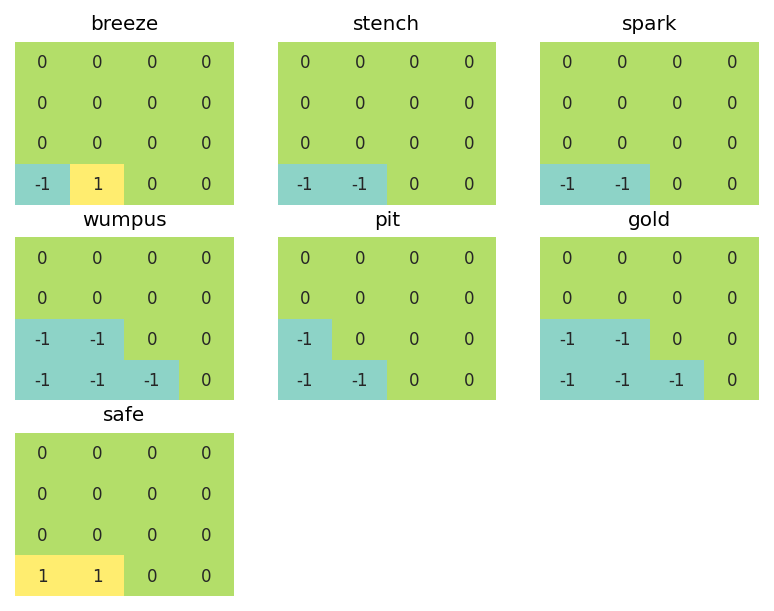

In [12]:
kb.visit((0, 1), ['breeze', 'safe'])

update (1, 0)
update (2, 0)
update (2, 0)
update (1, 1)


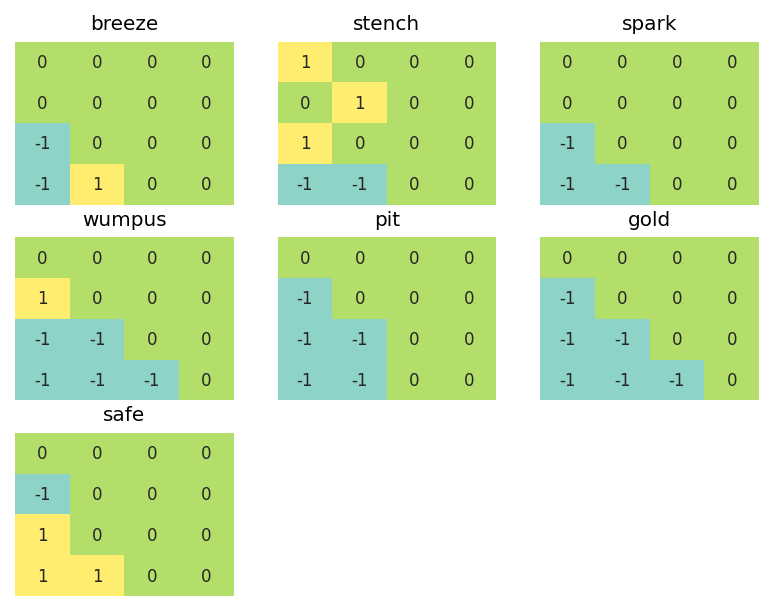

In [13]:
kb.visit((1, 0), ['stench', 'safe'])

这一步反映出我们虽然可以判断(2,0)是wumpus，但无法触发(0,2)的更新，因为我们并不知道(1,1)是由(0,2)触发的。
为了解决这个问题，后续的例子中我们加入一个全局判断

In [14]:
kb.ask((0, 1), 'safe')
kb.ask((1, 0), 'safe')
kb.ask((1, 1), 'safe')

01的safe为1
10的safe为1
无法判断11的safe
